# Photometric reduction

After an observation is done, a common need is to reduce and extract fluxes from raw FITS images. 

In this tutorial you will learn how to process a complete night of raw data from any telescope with some basic reduction tools provided by *prose*.

## Example data

You can follow this tutorial on your own data or generate a synthetic dataset. As an example, let's generate a light curve

(0.98, 1.02)

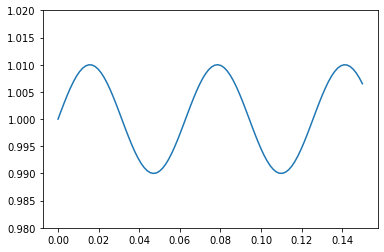

In [1]:
import numpy as np
import matplotlib.pyplot as plt

time = np.linspace(0, 0.15, 100)
target_dflux = 1 + np.sin(time*100)*1e-2

plt.plot(time, target_dflux)
plt.ylim(0.98, 1.02)

This might be the differential flux of a variable star. Let's now simulate the fits images associated with the observation of this target:

In [2]:
from prose.tutorials import simulate_observation

# so we have the same data
np.random.seed(40)

fits_folder = "./tutorial_dataset"
simulate_observation(time, target_dflux, fits_folder)

100%|██████████| 100/100 [00:05<00:00, 18.63it/s]


here prose simulated comparison stars, there fluxes over time and some systematics noises.

## Telescope setting

We start by setting up the `Telescope` information we need for the reduction, for example some fits keywords that are specific to this observatory plus few specs:

In [3]:
from prose import Telescope

_ = Telescope({
    "name": "A",
    "trimming": [40, 40],
    "pixel_scale": 0.66,
    "latlong": [31.2027, 7.8586],
    "keyword_light_images": "light"
})

Telescope 'a' saved


This has to be done **only once** and saves this telescope settings for any future use (whenever its name appears in fits headers). More details are given in the [telescope settings](../api/telescope.rst) note.

## Folder exploration

The first thing we want to do is to see what is contained within our folder. For that we instantiate a `FitsManager` object on our folder to describe its content

In [4]:
from prose import FitsManager

fm = FitsManager(fits_folder, depth=2)
fm.calib

100%|██████████| 106/106 [00:00<00:00, 798.87it/s]

╒════════════╤═════════════╤══════════╤══════════╤════════╤════════════╕
│ date       │ telescope   │ target   │ filter   │ type   │   quantity │
╞════════════╪═════════════╪══════════╪══════════╪════════╪════════════╡
│ 2021-04-22 │ A           │ prose    │          │ bias   │          1 │
├────────────┼─────────────┼──────────┼──────────┼────────┼────────────┤
│ 2021-04-22 │ A           │ prose    │          │ dark   │          1 │
├────────────┼─────────────┼──────────┼──────────┼────────┼────────────┤
│ 2021-04-22 │ A           │ prose    │ a        │ flat   │          4 │
├────────────┼─────────────┼──────────┼──────────┼────────┼────────────┤
│ 2021-04-22 │ A           │ prose    │ a        │ light  │        100 │
╘════════════╧═════════════╧══════════╧══════════╧════════╧════════════╛


We have 80 images of the *prose* target together with some calibration files. More info about the `FitsManager` object [here](./fits_manager.ipynb).

## Calibration and Photometry

*prose* provides basic pipelines for reduction and photometry. Using these, the `Calibration` is simply

In [5]:
from prose.pipeline import Calibration

destination = fm.obs_name

calibration = Calibration(**fm.images_dict)
calibration.run(destination)

RUN Calibration: 100%|████████████████████| 100/100 [00:14<00:00,  6.69images/s]


The previously set telescope has been recognized and a `A_20210128_prose_a` folder has been created in which we can now run the `AperturePhotometry`.

<div class="alert alert-info">

Note

`fm.obs_name` is just a conveniant attribute returning a string like `"telescope_target_date_filter"`

</div>

In [6]:
from prose.pipeline import AperturePhotometry

photometry = AperturePhotometry(calibration.images, calibration.stack)
photometry.run(calibration.phot_path)

RUN default: 100%|████████████████████████████| 1/1 [00:00<00:00,  6.97images/s]


INFO detected stars: 19
INFO global psf FWHM: 3.84 (pixels)


RUN Photometry: 100%|█████████████████████| 100/100 [00:10<00:00,  9.44images/s]


photometry.phot_pathHere is the content of the reduced folder:

```
A_20210128_prose_a/
  │ 
  ├── A_20210128_prose_a.phot
  ├── A_20210128_prose_a.gif
  ├── fake-im-0_reduced.fits
  ├── fake-im-1_reduced.fits
  ├── fake-im-2_reduced.fits
  └── ...
```

It contains:

- all reduced images
- a ``phot`` file containing all extracted fluxes and stack image (see [data products description](./phot.ipynb))
- a ``gif`` of the night 

`Calibration` and `AperturePhotometry` are modularly built out of `Blocks` and `Sequences`. Such pipelines can be built from scratch and even contain custom `Blocks` (like in the [next tutorial](./custom_pipeline.ipynb)).

## Photometry analysis

Let's load our data into an `Observation` object containing all we need for this analysis and show the detected stars

<Figure size 432x288 with 0 Axes>

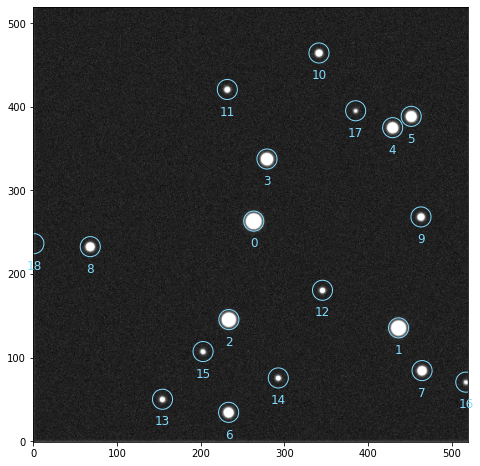

In [7]:
from prose import load

obs = load(photometry.phot_path)
obs.show_stars(size=8)

In [8]:
obs

<div class="alert alert-info">

Note

More details on the structure of these data products (and the representation above) in [data products description](./phot.ipynb)

</div>

If target was not specified in the reduction process (with a value of -1 as shown above), we need to specify it before producing our differential Photometry.

(0.98, 1.02)

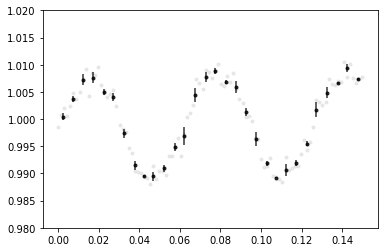

In [9]:
obs.target = 0
obs.broeg2005()
obs.plot()
plt.ylim(0.98, 1.02)

<div class="alert alert-info">

Note

We could also have picked the comparison stars ourselves using ``diff`` from `Observation`

</div>

We used the Broeg 2005 algorithm to build the differential light-curve and ended by plotting it. We can check the comparison stars with

<Figure size 432x288 with 0 Axes>

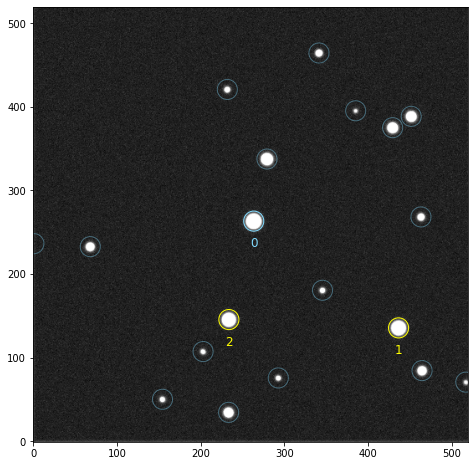

In [10]:
obs.show_stars(size=8)

and continue with further visualisation or analysis. All available plotting and analysis methods are described in `Observation`.

To save your analysis into the same phot file

In [11]:
obs.save()

## Some more details

### `Observation` plots

From the `Observation` object many things can be plotted. For example here are the comparison light curves as well as the systematics data:

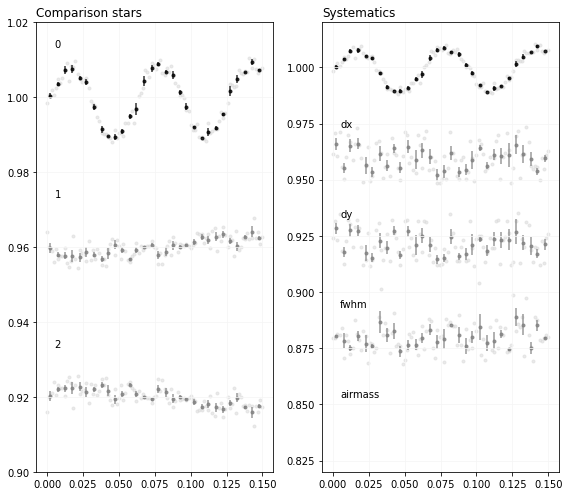

In [12]:
plt.figure(figsize=(8, 7))

plt.subplot(121)
obs.plot_comps_lcs()

plt.subplot(122)
obs.plot_systematics()

or effective some psf information

{'theta': 0.27815668692399975,
 'std_x': 1.6111565431453045,
 'std_y': 1.6507614286500747,
 'fwhm_x': 3.7939837234813347,
 'fwhm_y': 3.887246101749123}

<Figure size 432x288 with 0 Axes>

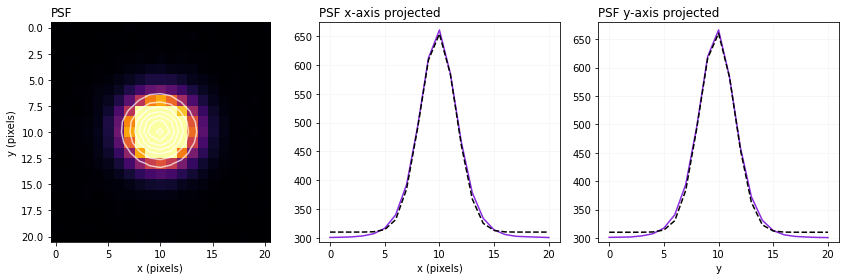

In [13]:
obs.plot_psf_fit()

here is another useful one showing the raw fluxes as well as the artificial light curve (a weighted mean of the comparison stars - see Broeg 2005 paper)

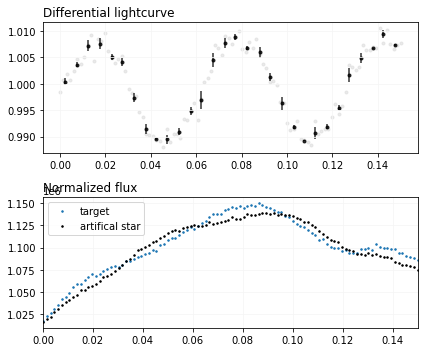

In [14]:
plt.figure(figsize=(6, 5))
obs.plot_raw_diff()

To see all possible plotting options check the `Observation` API

### Skiping the bias, flat, dark calibration

For some reasons you might want to run the reduction without doing any calibration. In that case just specify images with no calibration files:

In [15]:
from prose.pipeline import Calibration

uncalibrated_folder = "uncalibrated_folder"

calibration2 = Calibration(images=fm.images)
calibration2.run(destination=uncalibrated_folder)

INFO No bias images set
INFO No dark images set
INFO No flat images set


RUN Calibration: 100%|████████████████████| 100/100 [00:14<00:00,  6.84images/s]


see the `Calibration` API for more info

In [16]:
# hidden
from shutil import rmtree

rmtree(calibration.destination)
rmtree(calibration2.destination)
rmtree(fits_folder)